## **Retrain MobileNet V2 Classifier for Coral TPU Dev Board**

Fernando Rodriguez Jr

April 18th, 2023

EECS 6895: Advanced Big Data and AI Intelligence

NOTE: This code was based on the examples provided by google available at https://github.com/google-coral/tutorials#colab-tutorials-for-coral

# Retrain a classification model for Edge TPU using post-training quantization (with TF2)

Goals of this code:
1. Use TensorFlow 2 to create an image classification model
2. Train the model with datasat comprised of Embedded Device images
3. Convert the model to TensorFlow Lite using post-training quantization
4. Compile the TensorFlow Lite model for compatibility with the Coral Edge TPU Development Board

A base MobileNet V2 model will be repurposed for this retraining proceedure. The following steps will be taken to retrain the base model:
1. Retrain the classification layers by reusing MobileNet's pre-trained feature extractor layers
2. Fine-tune the model by updating weights in some of the feature extractor layers
3. Use post-training quantization to convert all parameters to int8 format for model size reduction, inferencing speed increase, and Coral Edge TPU compatibility.

## Import the required libraries

In [1]:
import os
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Download the training data from project's GitHub

In [2]:
# Download Compressed Folder and Add to Dir
_URL = "https://github.com/FernandoEE/EECS_6895_TPUvsNPU/blob/main/2_EmbeddedBoards_Datasets/Compressed_Dataset_Folders/Arty_Z7.tgz?raw=true"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="Arty_Z7.tgz", 
                                   extract=True)

16276138/16276138 [==============================] - 0s 0us/step


In [3]:
# Download Compressed Folder and Add to Dir
_URL = "https://github.com/FernandoEE/EECS_6895_TPUvsNPU/blob/main/2_EmbeddedBoards_Datasets/Compressed_Dataset_Folders/Basys_3.tgz?raw=true"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="Basys_3.tgz", 
                                   extract=True)

11984314/11984314 [==============================] - 0s 0us/step


In [4]:
# Download Compressed Folder and Add to Dir
_URL = "https://github.com/FernandoEE/EECS_6895_TPUvsNPU/blob/main/2_EmbeddedBoards_Datasets/Compressed_Dataset_Folders/Feather_HUZZAH.tgz?raw=true"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="Feather_HUZZAH.tgz", 
                                   extract=True)

22029210/22029210 [==============================] - 0s 0us/step


In [5]:
# Download Compressed Folder and Add to Dir
_URL = "https://github.com/FernandoEE/EECS_6895_TPUvsNPU/blob/main/2_EmbeddedBoards_Datasets/Compressed_Dataset_Folders/Rpi_3_Model_A%2B.tgz?raw=true"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="Rpi_3_Model_A%2B.tgz", 
                                   extract=True)

13934785/13934785 [==============================] - 0s 0us/step


In [6]:
# Download Compressed Folder and Add to Dir
_URL = "https://github.com/FernandoEE/EECS_6895_TPUvsNPU/blob/main/2_EmbeddedBoards_Datasets/Compressed_Dataset_Folders/Rpi_4_Model_B.tgz?raw=true"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="Rpi_4_Model_B.tgz", 
                                   extract=True)

16230831/16230831 [==============================] - 0s 0us/step


In [7]:
!mkdir /root/.keras/datasets/EmbeddedBoards_Datasets # Create the Main Training Dir

In [8]:
training_dataset_dir = "/root/.keras/datasets/EmbeddedBoards_Datasets" # Make Dataset Dir the main training dir

In [9]:
print(f"Main Training Dataset Dir: {training_dataset_dir}")

Main Training Dataset Dir: /root/.keras/datasets/EmbeddedBoards_Datasets


In [10]:
!ls -la /root/.keras/datasets/

total 78692
drwxr-xr-x 8 root root      4096 Apr 24 17:54 .
drwxr-xr-x 1 root root      4096 Apr 24 17:52 ..
-rwxr-xr-x 1  501 staff      249 Apr 18 15:04 ._Arty_Z7
drwxr-xr-x 2  501 staff    12288 Apr 18 15:04 Arty_Z7
-rw-r--r-- 1 root root  16276138 Apr 24 17:52 Arty_Z7.tgz
-rwxr-xr-x 1  501 staff      249 Apr 18 15:04 ._Basys_3
drwxr-xr-x 2  501 staff    12288 Apr 18 15:04 Basys_3
-rw-r--r-- 1 root root  11984314 Apr 24 17:52 Basys_3.tgz
drwxr-xr-x 2 root root      4096 Apr 24 17:54 EmbeddedBoards_Datasets
-rwxr-xr-x 1  501 staff      249 Apr 18 15:09 ._Feather_HUZZAH
drwxr-xr-x 2  501 staff    20480 Apr 18 15:09 Feather_HUZZAH
-rw-r--r-- 1 root root  22029210 Apr 24 17:53 Feather_HUZZAH.tgz
-rwxr-xr-x 1  501 staff      249 Apr 18 15:08 ._Rpi_3_Model_A+
drwxr-xr-x 2  501 staff    16384 Apr 18 15:08 Rpi_3_Model_A+
-rw-r--r-- 1 root root  13934785 Apr 24 17:53 Rpi_3_Model_A%2B.tgz
-rwxr-xr-x 1  501 staff      249 Apr 18 15:06 ._Rpi_4_Model_B
drwxr-xr-x 2  501 staff    20480 Apr 18 15:

In [11]:
# Clean Root Folder For Training
!rm -r /root/.keras/datasets/.*
!rm -r /root/.keras/datasets/*.tgz
!ls -la /root/.keras/datasets/

rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/.'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/..'
total 92
drwxr-xr-x 8 root root   4096 Apr 24 17:54 .
drwxr-xr-x 1 root root   4096 Apr 24 17:52 ..
drwxr-xr-x 2  501 staff 12288 Apr 18 15:04 Arty_Z7
drwxr-xr-x 2  501 staff 12288 Apr 18 15:04 Basys_3
drwxr-xr-x 2 root root   4096 Apr 24 17:54 EmbeddedBoards_Datasets
drwxr-xr-x 2  501 staff 20480 Apr 18 15:09 Feather_HUZZAH
drwxr-xr-x 2  501 staff 16384 Apr 18 15:08 Rpi_3_Model_A+
drwxr-xr-x 2  501 staff 20480 Apr 18 15:06 Rpi_4_Model_B


In [12]:
# Clean Individual Folders For Training
!rm -r /root/.keras/datasets/Arty_Z7/.*
!rm -r /root/.keras/datasets/Basys_3/.*
!rm -r /root/.keras/datasets/Feather_HUZZAH/.*
!rm -r /root/.keras/datasets/Rpi_3_Model_A+/.*
!rm -r /root/.keras/datasets/Rpi_4_Model_B/.*
!rm -r /root/.keras/datasets/EmbeddedBoards_Datasets/.*

rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Arty_Z7/.'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Arty_Z7/..'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Basys_3/.'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Basys_3/..'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Feather_HUZZAH/.'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Feather_HUZZAH/..'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Rpi_3_Model_A+/.'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Rpi_3_Model_A+/..'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Rpi_4_Model_B/.'
rm: refusing to remove '.' or '..' directory: skipping '/root/.keras/datasets/Rpi_4_Model_B/..'
rm: refusing to remove '.' or '..' directory: skipping '/root/.ke

In [13]:
# Move Board Datasets to main Training Folder
!mv /root/.keras/datasets/Arty_Z7/ /root/.keras/datasets/EmbeddedBoards_Datasets/
!mv /root/.keras/datasets/Basys_3/ /root/.keras/datasets/EmbeddedBoards_Datasets/
!mv /root/.keras/datasets/Feather_HUZZAH/ /root/.keras/datasets/EmbeddedBoards_Datasets/
!mv /root/.keras/datasets/Rpi_3_Model_A+/ /root/.keras/datasets/EmbeddedBoards_Datasets/
!mv /root/.keras/datasets/Rpi_4_Model_B/ /root/.keras/datasets/EmbeddedBoards_Datasets/

In [14]:
# Verify Move of Dirs
!ls -la  /root/.keras/datasets/
!ls -la  /root/.keras/datasets/EmbeddedBoards_Datasets

total 12
drwxr-xr-x 3 root root 4096 Apr 24 17:54 .
drwxr-xr-x 1 root root 4096 Apr 24 17:52 ..
drwxr-xr-x 7 root root 4096 Apr 24 17:54 EmbeddedBoards_Datasets
total 88
drwxr-xr-x 7 root root   4096 Apr 24 17:54 .
drwxr-xr-x 3 root root   4096 Apr 24 17:54 ..
drwxr-xr-x 2  501 staff 12288 Apr 24 17:54 Arty_Z7
drwxr-xr-x 2  501 staff 12288 Apr 24 17:54 Basys_3
drwxr-xr-x 2  501 staff 20480 Apr 24 17:54 Feather_HUZZAH
drwxr-xr-x 2  501 staff 16384 Apr 24 17:54 Rpi_3_Model_A+
drwxr-xr-x 2  501 staff 20480 Apr 24 17:54 Rpi_4_Model_B


* Use [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to rescale the image data into float values (divide by 255 so the tensor values are between 0 and 1)
* Call `flow_from_directory()` to create two generators: one for the training dataset and one for the validation dataset.


In [15]:
IMAGE_SIZE = 224
BATCH_SIZE = 64


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.3)

print(datagen)

train_generator = datagen.flow_from_directory(
    training_dataset_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    save_format='jpg',
    subset='training')

val_generator = datagen.flow_from_directory(
    training_dataset_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    save_format='jpg',
    subset='validation')

Found 700 images belonging to 5 classes.
Found 296 images belonging to 5 classes.



On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). For example, you can see the shapes here:

In [16]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

In [17]:
image_batch, label_batch = next(train_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

Now save the class labels to a text file:

In [18]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('Embedded_Devices_Class_Labels.txt', 'w') as f:
  f.write(labels)

{'Arty_Z7': 0, 'Basys_3': 1, 'Feather_HUZZAH': 2, 'Rpi_3_Model_A+': 3, 'Rpi_4_Model_B': 4}


In [19]:
!cat Embedded_Devices_Class_Labels.txt

Arty_Z7
Basys_3
Feather_HUZZAH
Rpi_3_Model_A+
Rpi_4_Model_B

## Build the model

* Create a model that's capable of transfer learning on just the last fully-connected layer

* Will use a MobileNet V2 from Keras as the base model
  * This is a pre-trained with the ImageNet dataset (trained to recognize 1,000 classes)
  * Provides us a great feature extractor for image classification that can be sued to train a new classification layer for the embedded devices dataset



In [20]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


### Add a classification head

In [21]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=5, activation='softmax')
])

### Configure the model

In [22]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 368,837
Non-tr

In [24]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model


* Training of the model using the `train_generator` and `val_generator` datasets

In [25]:
print(len(train_generator))
print(train_generator)

print(len(val_generator))
print(val_generator)

11
5


In [26]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
11/11 [==============================] - 28s 1s/step - loss: 0.7164 - accuracy: 0.7657 - val_loss: 0.1284 - val_accuracy: 0.9730
Epoch 2/10
11/11 [==============================] - 8s 737ms/step - loss: 0.0553 - accuracy: 0.9886 - val_loss: 0.0456 - val_accuracy: 0.9865
Epoch 3/10
11/11 [==============================] - 10s 951ms/step - loss: 0.0139 - accuracy: 0.9957 - val_loss: 0.0485 - val_accuracy: 0.9899
Epoch 4/10
11/11 [==============================] - 8s 728ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.0677 - val_accuracy: 0.9696
Epoch 5/10
11/11 [==============================] - 8s 702ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 0.9932
Epoch 6/10
11/11 [==============================] - 8s 738ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9932
Epoch 7/10
11/11 [==============================] - 8s 743ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9932
Epoch 8

### Review the learning curves


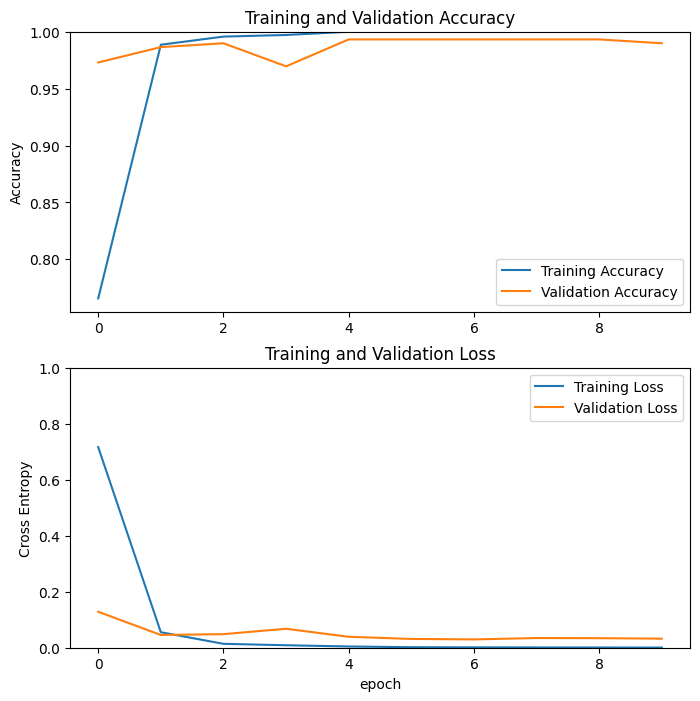

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model


### Un-freeze model layers


In [28]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [29]:
# Freeze the bottom 100 layers
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Reconfigure the model

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2,626,821
Trainable params: 2,230,277
Non-

In [32]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Continue training

In [33]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
11/11 [==============================] - 22s 838ms/step - loss: 0.5072 - accuracy: 0.8629 - val_loss: 0.0407 - val_accuracy: 0.9932
Epoch 2/5
11/11 [==============================] - 7s 675ms/step - loss: 0.0710 - accuracy: 0.9700 - val_loss: 0.0471 - val_accuracy: 0.9932
Epoch 3/5
11/11 [==============================] - 7s 658ms/step - loss: 0.0390 - accuracy: 0.9871 - val_loss: 0.0494 - val_accuracy: 0.9932
Epoch 4/5
11/11 [==============================] - 7s 654ms/step - loss: 0.0210 - accuracy: 0.9929 - val_loss: 0.0504 - val_accuracy: 0.9932
Epoch 5/5
11/11 [==============================] - 8s 743ms/step - loss: 0.0114 - accuracy: 0.9986 - val_loss: 0.0505 - val_accuracy: 0.9932


### Review the new learning curves

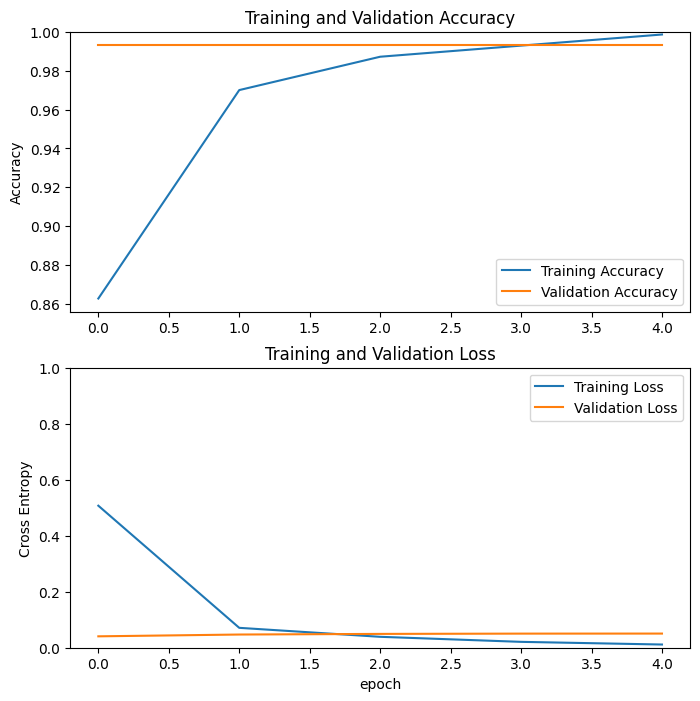

In [34]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('Embedded_Devices_mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

In [36]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(training_dataset_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('Embedded_Devices_mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### Compare the accuracy


In [37]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 100.000%


In [38]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('Embedded_Devices_mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 100.000%


## Compile for the Edge TPU


* Download Location of [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/)

In [39]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  13444      0 --:--:-- --:--:-- --:--:-- 13444
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [76.4 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Ign:7 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages
Hit:8 http://archive.ubuntu.com/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-up

In [40]:
! edgetpu_compiler Embedded_Devices_mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1154 ms.

Input model: Embedded_Devices_mobilenet_v2_1.0_224_quant.tflite
Input size: 2.94MiB
Output model: Embedded_Devices_mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 3.34MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: Embedded_Devices_mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


## Download the model

In [41]:
from google.colab import files
files.download('Embedded_Devices_mobilenet_v2_1.0_224.tflite')
files.download('Embedded_Devices_mobilenet_v2_1.0_224_quant.tflite')
files.download('Embedded_Devices_mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('Embedded_Devices_Class_Labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run the model on the Edge TPU




* Example model run on the  Coral TPU device

```
python3 classify_image.py \
  --model Embedded_Devices_mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels Embedded_Devices_Class_Labels.txt \
  --input <TEST PIC NAME>.jpg
```